<a href="https://colab.research.google.com/github/woipi90/PAApp/blob/master/DDPG_continuous(GrindingCircuit).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
# Install gym patch for continuous action space example in COLAB
!pip install gym[box2d]

In [2]:
# Access google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
# Navigate to drive folder in order to access files
import sys
sys.path.insert(0,'/content/gdrive/My Drive/Colab Notebooks/DDPG')

In [4]:
# RL imports
import gym
import numpy as np
from ddpg_torch import Agent
from utils import plotLearning

# Customized environment imports
from gym import Env
from gym.spaces import Box
import numpy as np
import random
from gym.utils import seeding
from gym import spaces

# Grinding Circuit Environment

In [5]:
class GrindingCircuit(Env):
  def __init__(self):
    # Initialize seed
    self.seed()

    # Useful range is -1 .. +1, but spikes can be higher
    self.observation_space = spaces.Box(-np.inf, np.inf, shape=(8,), dtype=np.float32)

    # Action is two floats [feedrate, separator speed].
    # Feedrate:         -1..+1 actual feedrate / max feedrate
    # Separator Speed:  -1..+1 separator speed / max separator speed
    self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)

    # Initialize vars
    self.productFineness          = np.inf
    self.recirculatingLoad        = np.inf
    self.targetproductFineness    = np.inf
    self.targetrecirculatingLoad  = np.inf
    self.separatorVentSpeed       = np.inf
    self.millMainVentSpeed        = np.inf
    self.proportionClinker        = np.inf
    self.proportionSlag           = np.inf

    # Simulation time
    self.initialSimulationLength = 1000
    self.simulationLength = self.initialSimulationLength

    # Trigger reset
    self.reset()
  
  # Make a step in the environment
  def step(self, action):
    # Update simulation length
    self.simulationLength -= 1

    # Action values
    action = np.clip(action, -1, +1).astype(np.float32)
    if action[0] > 0.0:
      self.feedRate = (action[0] + 1.0)*50        # 0..100 of max
    if action[1] > 0.0:
      self.separatorSpeed = (action[1] + 1.0)*50  # 0..100 of max

    # TODO - Implement mill simulation script and deliver output states


    # Consideres states
    # s[0] - Measured product size
    # s[1] - Measured recirculating load
    # s[2] - Targeted product size
    # s[3] - Targeted recirculating load
    # s[4] - Setting for the separator speed of the dynamic separator
    # s[5] - Setting for the separator speed of the mill main vantilator
    # s[6] - Proportion of the fresh feed being clinker (major influence --> hardness)
    # s[7] - Proportion of the fresh feed being slag (major influence --> hardness)
    state = [
      self.productFineness,
      self.recirculatingLoad,
      self.targetproductFineness,
      self.targetrecirculatingLoad,
      self.separatorVentSpeed,
      self.millMainVentSpeed,
      self.proportionClinker,
      self.proportionSlag
      ]
    
    # TODO - Implement reward function
    reward = 0

    # Check if simulation is done
    if self.simulationLength <= 0:
      done = True
    else:
      done = False

    # Set placeholder for info
    info = {}

    return np.array(state, dtype=np.float32), reward, done, info

  # TODO - Reset the environment
  def reset(self):
    # Reset simulation time
    self.simulationLength = self.initialSimulationLength
  
    return self.step(np.array([0, 0]))[0]

  # Seed
  def seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]

In [6]:
# Initialize grinding circuit environment
env = GrindingCircuit()
# Sample observation space to check if filled
env.observation_space.sample()

array([ 0.49417114, -0.12358999,  0.7134342 , -0.57819384, -1.6112323 ,
        0.8104983 ,  0.09919415, -0.5626872 ], dtype=float32)

# Machine Learning Config

episode  0 score 0.00 trailing 100 games avg 0.000
episode  1 score 0.00 trailing 100 games avg 0.000
episode  2 score 0.00 trailing 100 games avg 0.000
episode  3 score 0.00 trailing 100 games avg 0.000
episode  4 score 0.00 trailing 100 games avg 0.000
episode  5 score 0.00 trailing 100 games avg 0.000
episode  6 score 0.00 trailing 100 games avg 0.000
episode  7 score 0.00 trailing 100 games avg 0.000
episode  8 score 0.00 trailing 100 games avg 0.000
episode  9 score 0.00 trailing 100 games avg 0.000


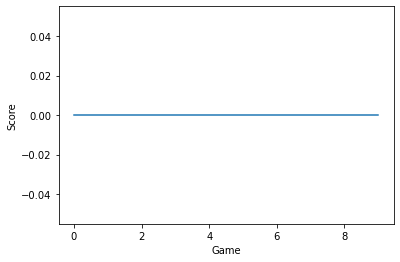

In [7]:
agent = Agent(alpha=0.000025, beta=0.00025, 
              input_dims=[8], tau=0.001, env=env,
              batch_size=40,  layer1_size=1024, layer2_size=1024, n_actions=2)

#agent.load_models()
np.random.seed(0)

score_history = []
for i in range(10):
    obs = env.reset()
    done = False
    score = 0
    while not done:
        act = agent.choose_action(obs)
        new_state, reward, done, info = env.step(act)
        agent.remember(obs, act, reward, new_state, int(done))
        agent.learn()
        score += reward
        obs = new_state
        #env.render()
    score_history.append(score)

    #if i % 25 == 0:
    #    agent.save_models()

    print('episode ', i, 'score %.2f' % score,
          'trailing 100 games avg %.3f' % np.mean(score_history[-100:]))

filename = 'LunarLander-alpha000025-beta00025-400-300.png'
plotLearning(score_history, filename, window=100)